# SVM for Load Forecasting


## Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.arrays import categorical
from pandas.core.arrays.categorical import Categorical
from ipywidgets.widgets.widget_controller import Axis

## Loading the Dataset using Pandas

In [2]:
df=pd.read_csv("/content/data_modified_set.csv")
df.head()

,Date,Time,Current(A),Voltage(Kv),P.F,Power(Kw),Weekday/Weekend,Season,Zones,Temperature(C),Humidity,CloudCover(%),Wind speed
0,2022-07-16,01-00,223.0,11.4,0.99,4359,0,1,2,26.2,73,48,13.5
1,2022-07-16,02-00,220.0,11.4,0.99,4301,0,1,2,26.1,73,52,14.0
2,2022-07-16,03-00,196.0,11.4,0.99,3831,0,1,2,25.7,74,38,12.8
3,2022-07-16,04-00,195.0,11.3,0.99,3778,0,1,2,25.4,75,41,11.8
4,2022-07-16,05-00,204.0,11.2,0.99,3918,0,1,2,25.2,75,43,12.6


##Changing the Data Types of the features

In [3]:
df['Date']=pd.to_datetime(df['Date'])
df['Current(A)'].astype(float)
df['Voltage(Kv)'].astype(float)
df['P.F'].astype(float)
df['Power(Kw)'].astype(int)
df['Weekday/Weekend'].astype(int)
df['Season'].astype(int)
df['Zones']=pd.Categorical(df['Zones'])
df['Temperature(C)'].astype(float)
df['Humidity'].astype(int)
df['CloudCover(%)'].astype(float)
df['Wind speed'].astype(float)
df.dtypes

Date               datetime64[ns]
Time                       object
Current(A)                float64
Voltage(Kv)               float64
P.F                       float64
Power(Kw)                   int64
Weekday/Weekend             int64
Season                      int64
Zones                    category
Temperature(C)            float64
Humidity                    int64
CloudCover(%)               int64
Wind speed                float64
dtype: object

## Describing the Dataset

In [4]:
df.describe()

,Date,Current(A),Voltage(Kv),P.F,Power(Kw),Weekday/Weekend,Season,Temperature(C),Humidity,CloudCover(%),Wind speed
count,9552,9552.000000,9552.000000,9.552000e+03,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000
mean,2023-01-30 12:00:00,327.604010,11.030911,9.900000e-01,6175.724246,0.143216,1.914573,26.982025,63.498848,33.974874,8.901392
min,2022-07-16 00:00:00,125.000000,10.400000,9.900000e-01,2443.000000,0.000000,1.000000,13.300000,15.000000,0.000000,0.000000
25%,2022-10-23 00:00:00,263.000000,10.900000,9.900000e-01,4999.750000,0.000000,1.000000,24.300000,47.000000,4.000000,5.700000
50%,2023-01-30 12:00:00,322.000000,11.000000,9.900000e-01,6074.000000,0.000000,2.000000,26.700000,66.000000,28.000000,8.100000
75%,2023-05-10 00:00:00,373.000000,11.200000,9.900000e-01,7017.000000,0.000000,3.000000,29.600000,80.000000,54.000000,11.400000
max,2023-08-17 00:00:00,715.000000,11.900000,9.900000e-01,13364.000000,1.000000,3.000000,40.900000,99.000000,100.000000,28.300000
std,NaN,95.053952,0.207911,1.110281e-16,1717.433796,0.350311,0.831425,4.650102,20.771927,31.342074,4.420345


## Data Preprocessing

In [5]:
df['Day']=df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df['Hour'] = df['Time'].str.split('-').str[0]
df['Hour']=df['Hour'].astype(int)
df=df.drop(['Time','Date'], axis=1)
df_dum=pd.get_dummies(df,drop_first=True)
print(df_dum.shape)
df_dum.drop(['Current(A)','Voltage(Kv)','P.F'],axis=1,inplace=True)
df_dum.head()

(9552, 17)


,Power(Kw),Weekday/Weekend,Season,Temperature(C),Humidity,CloudCover(%),Wind speed,Day,Month,Year,Hour,Zones_1,Zones_2,Zones_3
0,4359,0,1,26.2,73,48,13.5,16,7,2022,1,False,True,False
1,4301,0,1,26.1,73,52,14.0,16,7,2022,2,False,True,False
2,3831,0,1,25.7,74,38,12.8,16,7,2022,3,False,True,False
3,3778,0,1,25.4,75,41,11.8,16,7,2022,4,False,True,False
4,3918,0,1,25.2,75,43,12.6,16,7,2022,5,False,True,False


### Data Spliting and Standardization

In [6]:
#rbf when c=1
y = df_dum['Power(Kw)']
X = df_dum.drop(['Power(Kw)'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
scalar=StandardScaler()
scalar.fit(X_train)
X_train_scalar=scalar.transform(X_train)
X_test_scalar=scalar.transform(X_test)
X_test.shape

(478, 13)

## Model Development


*   Model is developed after trying different combinations of Hyperparameters and kernels
* Best Hyperparameters are C= 1000, Epsilon= 0.1 and Gamma=0.1
* Best Kernel is Radial Basis Function




In [7]:
#rbf when c=1000
svr1000=SVR(kernel='rbf',C=1000,gamma=0.1)
svr1000.fit(X_train_scalar,y_train)

SVR(C=1000, gamma=0.1)

## Model Evalution
* Training and Testing MAPE (Mean Absolute Percentage Error)

In [8]:
#training metrics when c=1000
y_train_pred1000=svr1000.predict(X_train_scalar)
def mean_absolute_percentage_error(y_train, y_train_pred1000):
    return np.mean(np.abs((y_train - y_train_pred1000) / y_train)) * 100
mape1000 = mean_absolute_percentage_error(y_train, y_train_pred1000)
print("Mean Absolute Percentage Error of Training Set is:",mape1000)

Mean Absolute Percentage Error of Training Set is: 6.354392911708301


In [9]:
#testing metrics when c=1000
y_pred_test1000=svr1000.predict(X_test_scalar)
def mean_absolute_percentage_error(y_test, y_pred_test1000):
    return np.mean(np.abs((y_test - y_pred_test1000) / y_test)) * 100
mape_test1000 = mean_absolute_percentage_error(y_test, y_pred_test1000)
print("Mean Absolute Percentage Error of Testing Set is",mape_test1000)

Mean Absolute Percentage Error of Testing Set is 7.250040596153455


<Axes: >

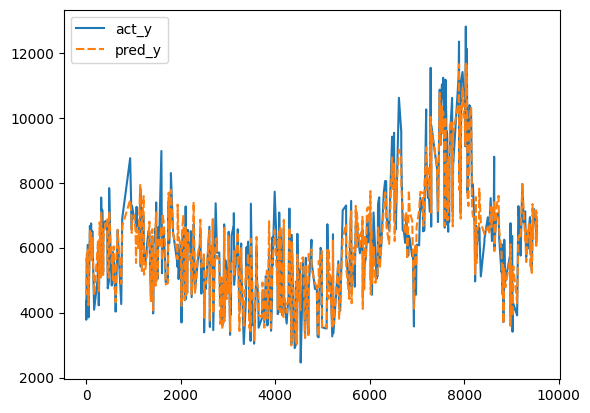

In [14]:
predict=pd.DataFrame({'act_y':y_test, 'pred_y':y_pred_test1000})
sns.lineplot(predict)

## Testing the with unseen data and predicting 1 week future load

In [25]:
df=pd.read_csv("/content/csv_aug_sept_oct.csv")
df=df.iloc[:168]
df.head()

,Date,Time,Current(A),Voltage(Kv),P.F,Power(Kw),Weekday/Weekend,Season,Zones,Temperature(C),Humidity,CloudCover(%),Wind speed
0,2023-08-18,01-00,314,11.2,0.99,6030,0,0,2,25.1,90,78,6.8
1,2023-08-18,02-00,293,11.1,0.99,5577,0,0,2,24.9,89,81,9.4
2,2023-08-18,03-00,284,11.1,0.99,5406,0,0,2,24.5,88,31,10.5
3,2023-08-18,04-00,277,11.1,0.99,5272,0,0,2,24.3,89,63,10.8
4,2023-08-18,05-00,281,11.1,0.99,5348,0,0,2,24.1,88,83,11.3


In [28]:
df['Date']=pd.to_datetime(df['Date'])
df['Current(A)'].astype(float)
df['Voltage(Kv)'].astype(float)
df['P.F'].astype(float)
df['Power(Kw)'].astype(int)
df['Weekday/Weekend'].astype(int)
df['Season'].astype(int)
df['Zones']=pd.Categorical(df['Zones'])
df['Temperature(C)'].astype(float)
df['Humidity'].astype(int)
df['CloudCover(%)'].astype(float)
df['Wind speed'].astype(float)
df.describe()
df['Day']=df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df['Hour'] = df['Time'].str.split('-').str[0]
df['Hour']=df['Hour'].astype(int)
df=df.drop(['Time','Date'], axis=1)
df_dum=pd.get_dummies(df,drop_first=True)
print(df_dum.shape)
df_dum.drop(['Current(A)','Voltage(Kv)','P.F'],axis=1,inplace=True)
df_dum.head()

(168, 17)


,Power(Kw),Weekday/Weekend,Season,Temperature(C),Humidity,CloudCover(%),Wind speed,Day,Month,Year,Hour,Zones_1,Zones_2,Zones_3
0,6030,0,0,25.1,90,78,6.8,18,8,2023,1,False,True,False
1,5577,0,0,24.9,89,81,9.4,18,8,2023,2,False,True,False
2,5406,0,0,24.5,88,31,10.5,18,8,2023,3,False,True,False
3,5272,0,0,24.3,89,63,10.8,18,8,2023,4,False,True,False
4,5348,0,0,24.1,88,83,11.3,18,8,2023,5,False,True,False


In [29]:
y_future = df_dum['Power(Kw)']
X = df_dum.drop(['Power(Kw)'],axis=1)
scalar=StandardScaler()
scalar.fit(X)
X_train_scalar1=scalar.transform(X)
X_train_scalar1.shape
X.head()

,Weekday/Weekend,Season,Temperature(C),Humidity,CloudCover(%),Wind speed,Day,Month,Year,Hour,Zones_1,Zones_2,Zones_3
0,0,0,25.1,90,78,6.8,18,8,2023,1,False,True,False
1,0,0,24.9,89,81,9.4,18,8,2023,2,False,True,False
2,0,0,24.5,88,31,10.5,18,8,2023,3,False,True,False
3,0,0,24.3,89,63,10.8,18,8,2023,4,False,True,False
4,0,0,24.1,88,83,11.3,18,8,2023,5,False,True,False


In [32]:
y_pred_test1000=svr1000.predict(X_train_scalar1)
def mean_absolute_percentage_error(y_future, y_pred_test1000):
    return np.mean(np.abs((y_future - y_pred_test1000) / y)) * 100
mape_test1000 = mean_absolute_percentage_error(y_future, y_pred_test1000)
print(f"One week ahead forecating mape error:", {mape_test1000})

One week ahead forecating mape error: {10.87752650978971}


In [33]:
predict=pd.DataFrame({'act_y':y_future, 'pred_y':y_pred_test1000})
predict.head(24)

,act_y,pred_y
0,6030,4130.298876
1,5577,3877.204559
2,5406,4624.598909
3,5272,3924.816749
4,5348,3639.538963
5,6093,5738.098260
6,7426,6135.953164
7,7093,6593.254861
8,6426,6756.545002
9,6430,5663.455582


<Axes: >

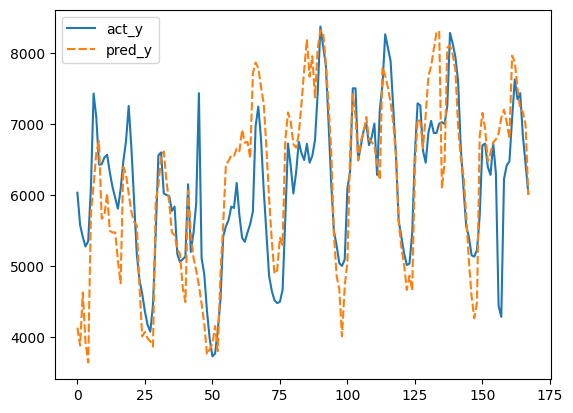

In [34]:
sns.lineplot(predict)